In [1]:
%run functions.ipynb

Ready: 2023-04-27 02:29:21


In [2]:
findspark.init()
from pyspark.sql import SparkSession
try:
    spark.stop()
except:
    pass
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

spark

In [3]:
df_schema = StructType([StructField('user', StringType(), True), StructField('proj', StringType(), True), StructField('rubricName', StringType(), True), StructField('rubricID', IntegerType(), True), StructField('time', StringType(), True), StructField('date', StringType(), True), StructField('org', StringType(), True), StructField('branch', StringType(), True), StructField('prod', StringType(), True), StructField('tx', StringType(), True), StructField('fl', StringType(), True), StructField('devmod', StringType(), True), StructField('lat', StringType(), True), StructField('lon', StringType(), True)])
df_list = [i for i in files_list_chain if 'Астана' in i or 'Бишкек' in i or 'Москва' in i or 'ОАЭ' in i or 'Ташкент' in i]
df_list_new = [i for i in files_list_chain if i not in df_list]

In [4]:
for file in tqdm(df_list_new):
    df = spark.read.option("header","true").csv(file, schema=df_schema)
    df.createOrReplaceTempView('df')
    city = file.split('\\')[2]
    df_new = spark.sql(f'''
    select 
    rubricName
    , "{city}" city
    , time
    , year(time) year_r
    , hour(time) hour_r
    , SUBSTR(time, 6, 5) date_r
    , case when weekofyear(time) > 9 then 1 else weekofyear(time) end week_r
    , case when extract(dayofweek from time) = 1 then 7
        else extract(dayofweek from time)-1
    end week_day_r

    from df
    ''').where('year_r in (2020,2021,2022,2023) and month(time) < 3 ')

    df_new.write.mode('append').parquet(f'files/ten_city/df_dates')

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:07:21<00:00, 202.06s/it]


In [6]:
spark.read.parquet(f'files/ten_city/df_dates').where('rubricName is not null').count()

906098201

In [7]:
spark.read.parquet(f'files/ten_city/df_dates').count()

1759325082

In [3]:
df_dates = spark.read.parquet(f'files/ten_city/df_dates')
df_dates.createOrReplaceTempView('df_dates')

In [4]:
for col_r in tqdm(['hour_r', 'date_r', 'week_r', 'week_day_r']):
    df_col = spark.sql(f'''       
    select 
        year_r
        , rubricName
        , city
        , {col_r}
        , count(*) cnt
    from df_dates
    group by
        year_r
        , rubricName
        , city
        , {col_r}
    ''')

    df_col.write.mode('overwrite').parquet(f'files/ten_city/df_dates_{col_r}')
    
    df_dates_col = spark.read.parquet(f'files/ten_city/df_dates_{col_r}')
    df_dates_col.createOrReplaceTempView('df_dates_col')
    df_norm = spark.sql(f'''       
    select 
        year_r
        , rubricName
        , city
        , {col_r}
        , sum(cnt) over(partition by rubricName, {col_r}) / sum(cnt) over(partition by rubricName)*100 cnt
    from df_dates_col
    ''')

    df_norm.write.mode('overwrite').parquet(f'files/ten_city/df_dates_norm_{col_r}')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [24:16<00:00, 364.05s/it]


In [193]:
path = f'files/ten_city/df_dates_rubrics.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

for col_r in tqdm(['hour_r', 'date_r', 'week_r', 'week_day_r']):
    df_piv = spark.read.parquet(f'files/ten_city/df_dates_norm_{col_r}')
    df_piv = df_piv.groupBy("rubricName").pivot(col_r).sum("cnt")
    
    for i in [i for i in df_piv.columns if i!='rubricName']:
        df_piv = df_piv.withColumnRenamed(i, 'c'+i.replace('-','_'))
        
    df_piv_mean = df_piv.toPandas().mean()
    df_piv_pd = df_piv.toPandas()
    for i in range(df_piv_pd.shape[0]):
        df_piv_pd.at[i, 'diff'] = abs(abs(df_piv_mean - df_piv_pd.iloc[i]).sum() / df_piv_mean.sum())
    df_piv_pd = df_piv_pd[['rubricName','diff']]
    
    df_piv_pd.to_excel(writer,index=False, sheet_name=col_r)
    
writer.close()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\Mamed\AppData\Local\Temp\ipykernel_4424\1517692780.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_piv_mean = df_piv.toPandas().mean()
 25%|█████████████████████                                                               | 1/4 [00:02<00:06,  2.25s/it]C:\Users\Mamed\AppData\Local\Temp\ipykernel_4424\1517692780.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_piv_mean = df_piv.toPandas().mean()
 50%|██████████████████████████████████████████                                          | 2/4 [00:10<00:11,  5.96s/it

In [192]:
path = f'files/ten_city/df_dates_city.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

for col_r in tqdm(['hour_r', 'date_r', 'week_r', 'week_day_r']):
    df_piv = spark.read.parquet(f'files/ten_city/df_dates_norm_{col_r}')
    df_piv = df_piv.groupBy("city").pivot(col_r).sum("cnt")

    for i in [i for i in df_piv.columns if i!='city']:
        df_piv = df_piv.withColumnRenamed(i, 'c'+i.replace('-','_'))
        
    df_piv_mean = df_piv.toPandas().mean()
    df_piv_pd = df_piv.toPandas()
    for i in range(df_piv_pd.shape[0]):
        df_piv_pd.at[i, 'diff'] = abs(abs(df_piv_mean - df_piv_pd.iloc[i]).sum() / df_piv_mean.sum())
    df_piv_pd = df_piv_pd[['city','diff']]
    
    df_piv_pd.to_excel(writer, index=False, sheet_name=col_r)
    
writer.close()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\Mamed\AppData\Local\Temp\ipykernel_4424\785717733.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_piv_mean = df_piv.toPandas().mean()
 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.38it/s]C:\Users\Mamed\AppData\Local\Temp\ipykernel_4424\785717733.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_piv_mean = df_piv.toPandas().mean()
 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:01,  1.00it/s]C

In [191]:
path = f'files/ten_city/df_dates_rubrics_city.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')
for col_r in tqdm(['hour_r', 'date_r', 'week_r', 'week_day_r']):
    df_piv = spark.read.parquet(f'files/ten_city/df_dates_norm_{col_r}')
    df_piv = df_piv.groupBy(["rubricName", "city"]).pivot(col_r).sum("cnt")

    for i in [i for i in df_piv.columns if i!='city' and i!='rubricName']:
        df_piv = df_piv.withColumnRenamed(i, 'c'+i.replace('-','_'))
        
    df_piv_mean = df_piv.toPandas().mean()
    df_piv_pd = df_piv.toPandas()
    for i in range(df_piv_pd.shape[0]):
        df_piv_pd.at[i, 'diff'] = abs(abs(df_piv_mean - df_piv_pd.iloc[i]).sum() / df_piv_mean.sum())
    df_piv_pd = df_piv_pd[["rubricName", "city",'diff']]
    
    df_piv_pd.to_excel(writer,index=False, sheet_name=col_r)
writer.close()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\Mamed\AppData\Local\Temp\ipykernel_4424\671971408.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_piv_mean = df_piv.toPandas().mean()
 25%|█████████████████████                                                               | 1/4 [00:11<00:33, 11.16s/it]C:\Users\Mamed\AppData\Local\Temp\ipykernel_4424\671971408.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_piv_mean = df_piv.toPandas().mean()
 50%|██████████████████████████████████████████                                          | 2/4 [00:38<00:41, 20.60s/it]C

In [201]:
dates = [r"C:\Users\Mamed\_Notebooks\2GIS_2023\files\ten_city\df_dates_city.xlsx",
r"C:\Users\Mamed\_Notebooks\2GIS_2023\files\ten_city\df_dates_rubrics.xlsx",
r"C:\Users\Mamed\_Notebooks\2GIS_2023\files\ten_city\df_dates_rubrics_city.xlsx"]

In [212]:
file.split('\\')[-1].replace('.xlsx','')

'df_dates_rubrics_city'

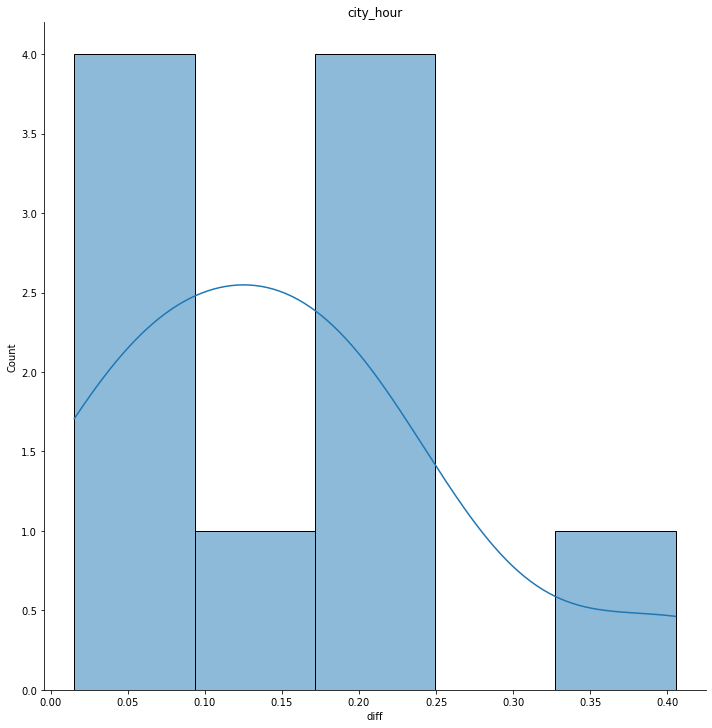

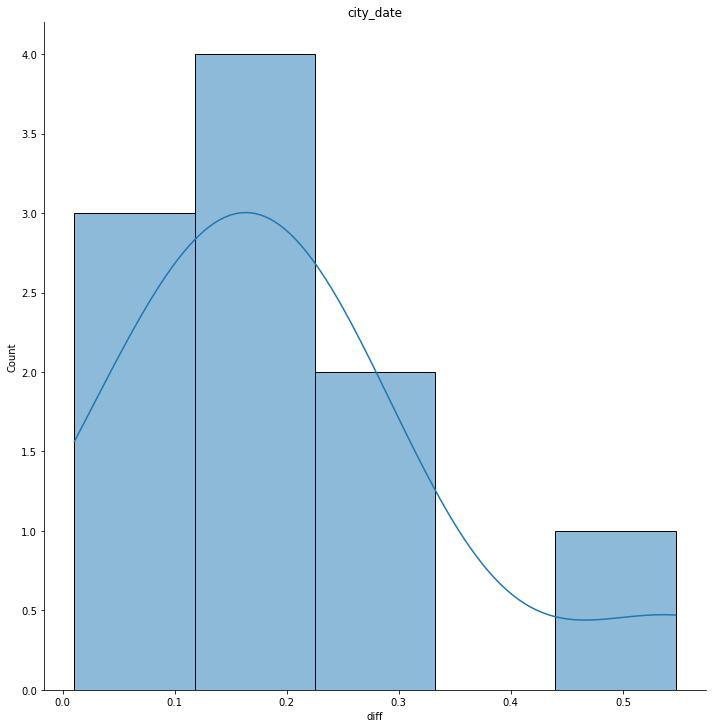

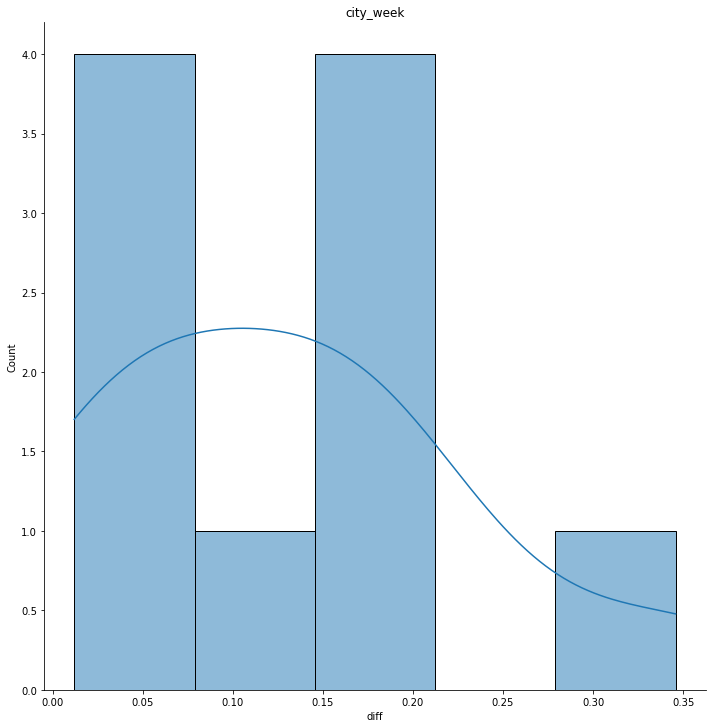

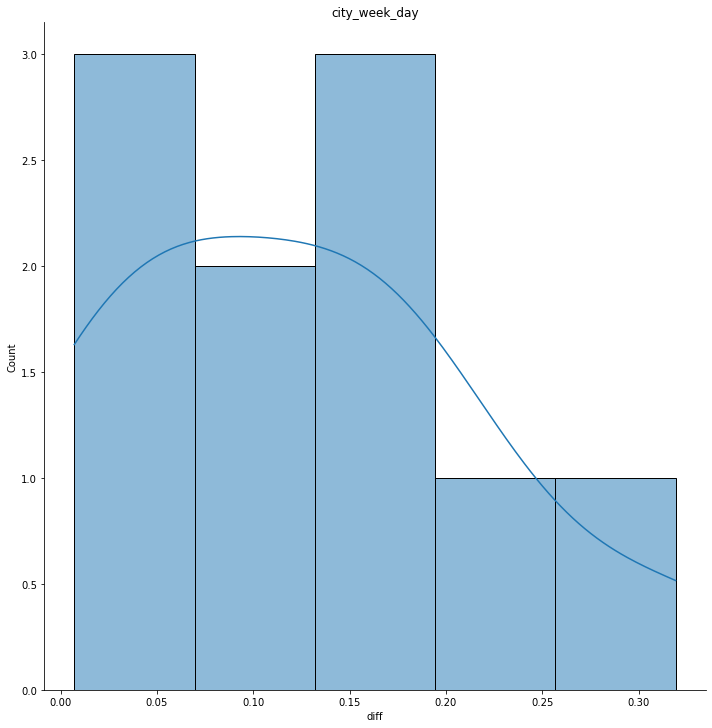

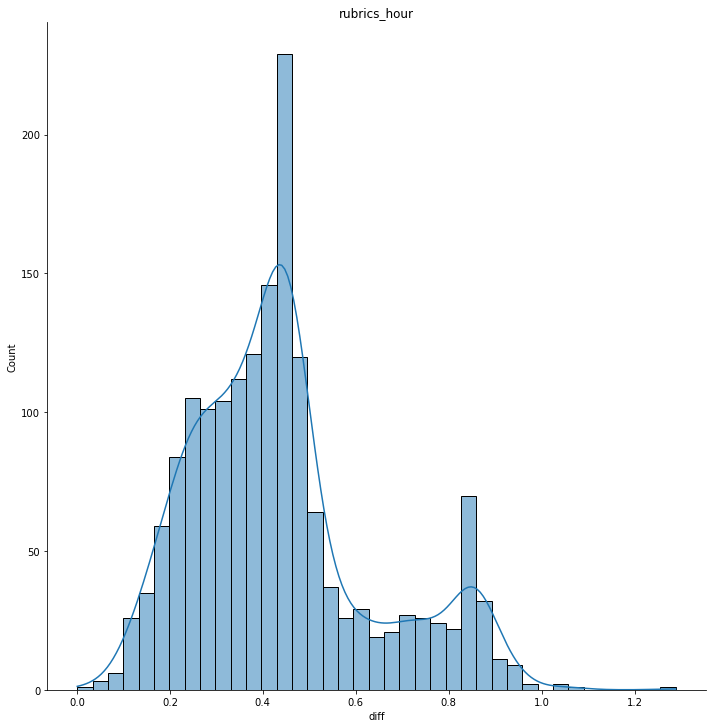

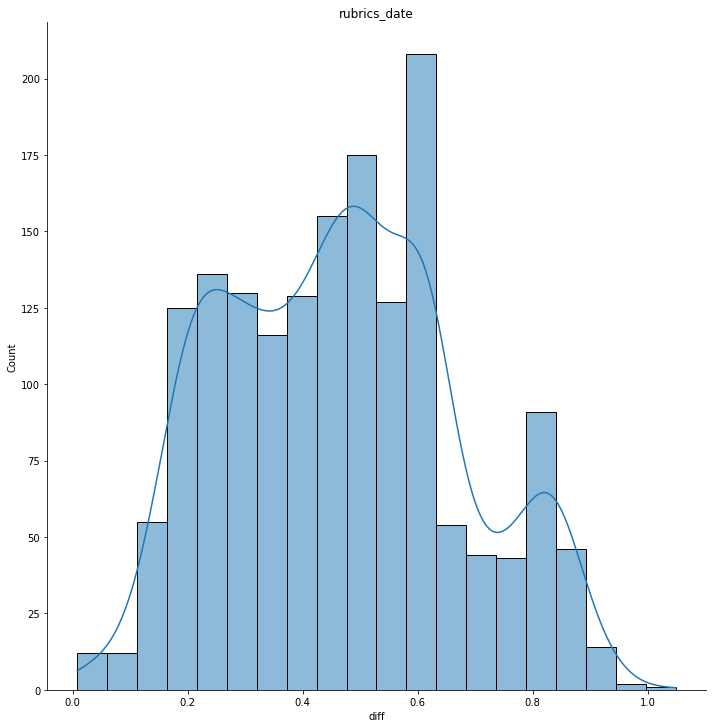

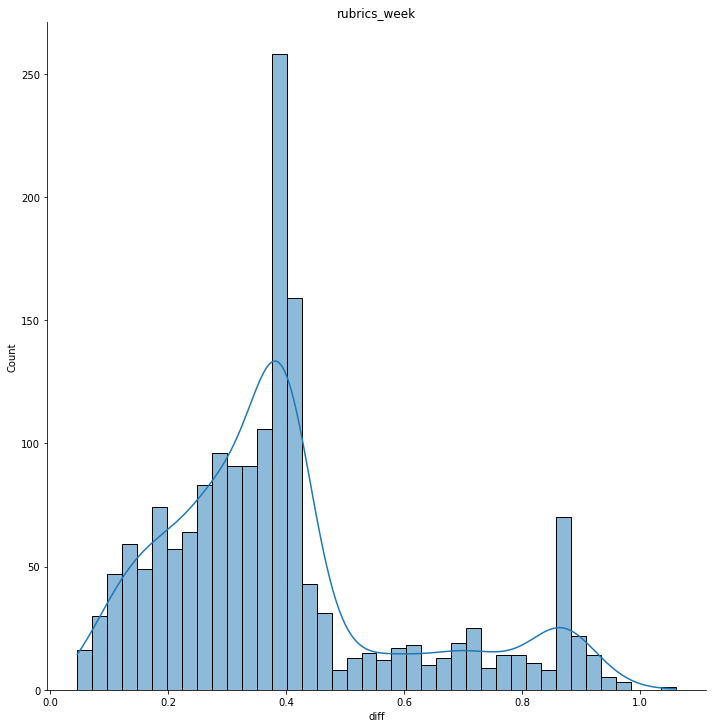

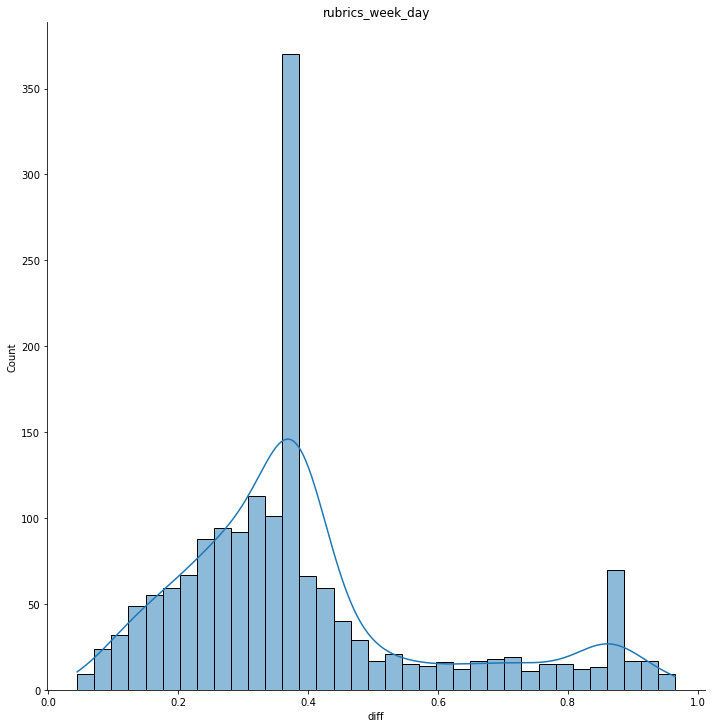

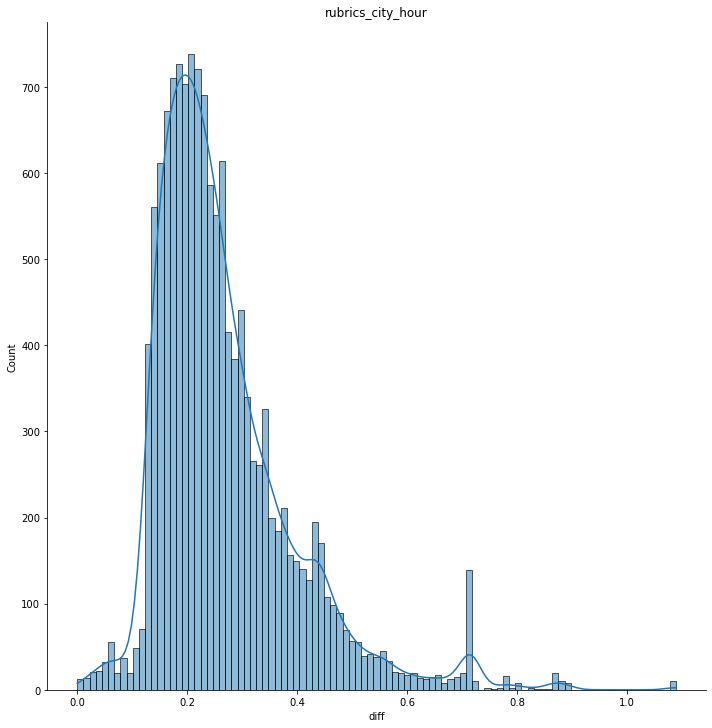

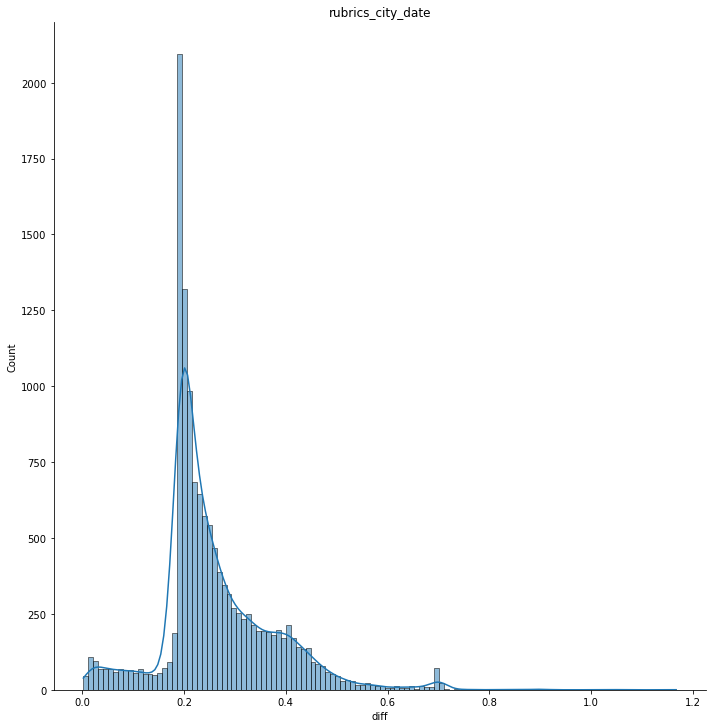

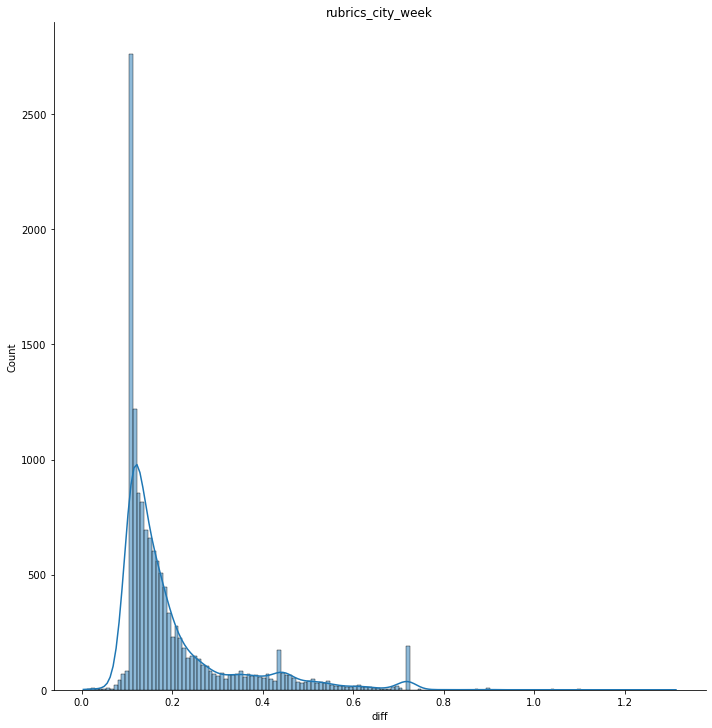

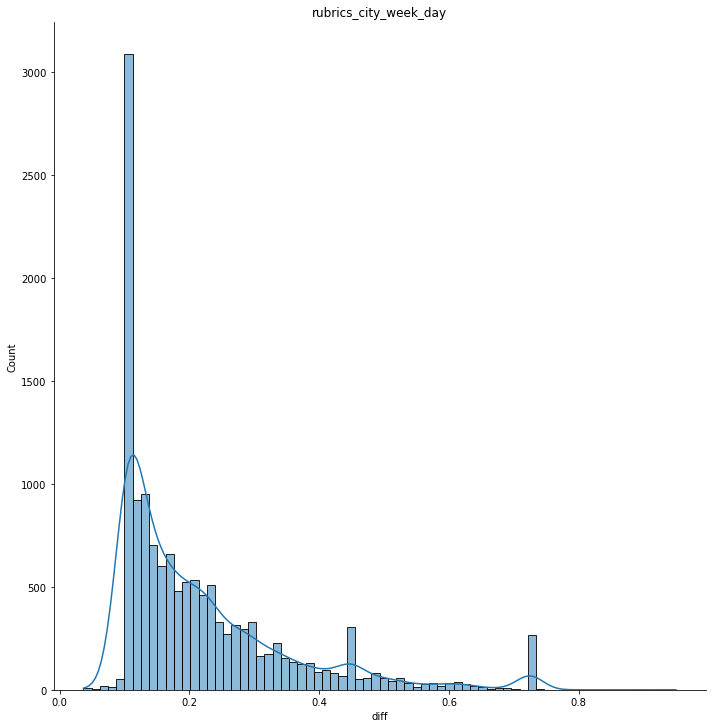

In [217]:
i = 0

for file in dates:
    for col_r in ['hour_r', 'date_r', 'week_r', 'week_day_r']:
        xr = pd.read_excel(file, sheet_name=col_r)
        file_name = file.split('\\')[-1].replace('.xlsx','').replace('df_dates_','')
        sns_plot = sns.displot(data=xr, x="diff", kde=True, height=10).set(title=f'{file_name}_{col_r}'.replace('_r',''))
        fig = sns_plot.figure
        i+=1
        fig.savefig(f"pictures/ten_city/displot_{i}.png")

In [ ]:
def count_dates(col, df_new='df_new'):
    dff1 = spark.sql(f'''

    with t as
        (
        select 
            year_r
            , rubricName
            , city
            , {col}
            , count(*) cnt
        from {df_new}
        group by
            year_r
            , rubricName
            , city
            , {col}
        order by
            year_r
            , rubricName
            , city
            , {col}
        )
    ,gr as
        (
        select
            rubricName 
            ,{col} 
            ,max(case when city = 'Астана'  then cnt end) cnt_a
            ,max(case when city = 'Бишкек'  then cnt end) cnt_b
            ,max(case when city = 'Москва'  then cnt end) cnt_m
            ,max(case when city = 'ОАЭ'     then cnt end) cnt_o
            ,max(case when city = 'Ташкент' then cnt end) cnt_t
        from t
        group by
            rubricName
            ,{col}
        order by
            rubricName
            ,{col}    
        )

    select
        rubricName 
        ,{col}
        ,sum(cnt_a) over(partition by rubricName, {col}) / sum(cnt_a) over(partition by rubricName)*100 cnt_a
        ,sum(cnt_b) over(partition by rubricName, {col}) / sum(cnt_b) over(partition by rubricName)*100 cnt_b
        ,sum(cnt_m) over(partition by rubricName, {col}) / sum(cnt_m) over(partition by rubricName)*100 cnt_m
        ,sum(cnt_o) over(partition by rubricName, {col}) / sum(cnt_o) over(partition by rubricName)*100 cnt_o
        ,sum(cnt_t) over(partition by rubricName, {col}) / sum(cnt_t) over(partition by rubricName)*100 cnt_t
        
    from gr

    ''').toPandas()
    return dff1

In [ ]:
def make_dates_file(name):
    df = spark.read.parquet(f'files/df_filtered_{name}')
    df.createOrReplaceTempView('df')

    df_new = spark.sql('''

    select 
    rubricName
    , time
    , year(time) year_r
    , hour(time) hour_r
    , SUBSTR(time, 6, 5) date_r
    , case when weekofyear(time) > 9 then 1 else weekofyear(time) end week_r
    , case when extract(dayofweek from time) = 1 then 7
        else extract(dayofweek from time)-1
    end week_day_r

    from df
    ''')

    df_new.write.mode('overwrite').parquet(f'files/df_dates_{name}')

    df_new = spark.read.parquet(f'files/df_dates_{name}').where('year_r in (2020,2021,2022,2023) and month(time) < 3 ')
    df_new.createOrReplaceTempView('df_new')

    dff1 = count_dates('hour_r')
    dff2 = count_dates('date_r')
    dff3 = count_dates('week_r')
    dff4 = count_dates('week_day_r')

    t = ['Рубрика','Час','Количество запросов 2020','Количество запросов 2021','Количество запросов 2022','Количество запросов 2023',
        'max_2020','max_2021','max_2022','max_2023','min_2020','min_2021','min_2022','min_2023','up_2021','up_2022','up_2023','down_2021','down_2022','down_2023', 'delta_score']


    t[1] = 'Час'
    dff1.columns = t
    t[1] = 'Дата'
    dff2.columns = t
    t[1] = 'Неделя'
    dff3.columns = t
    t[1] = 'День недели'
    dff4.columns = t

    with pd.ExcelWriter(f'files/df_dates_{name}.xlsx') as writer:
        dff1.to_excel(writer, sheet_name='Часы', index=False)
        dff2.to_excel(writer, sheet_name='Даты', index=False)
        dff3.to_excel(writer, sheet_name='Недели', index=False)
        dff4.to_excel(writer, sheet_name='Дни недели', index=False)